# Minimal example of SyncRad usage
## Undulator radiation

In [1]:
# Imports

%matplotlib notebook
import matplotlib.pyplot as plt

import sys, time
import numpy as np

from synchrad.calc import SynchRad
from synchrad.utils import J_in_um

In [2]:
# Undulator
K0 = 0.1           # Strength
Periods = 50       # Number of periods

# Particles and tracks characteristics
Np = 10            # Number of particles 
g0 = 100.          # Mean Lorentz factor
dg = 1e-3*g0       # Energy spread 
StepsPerPeriod=32  # Track temporal resolution

# Mean particles longitudinal velocity and central wavenumber
gg = g0/(1.+K0**2/2)**.5
vb = (1.-gg**-2)**0.5
k_res = 2*gg**2

# Time step and total number of steps
dt = 1./StepsPerPeriod
Steps2Do = int((Periods+2)/dt)+1

# Calculating the particles orbits (simplified)
def uzFunctionUndulator(x):
    val = K0*np.sin(2*np.pi*x)
    val *= (x>0)*(x<1.5)*x/1.5 + (x>1.5)
    val *= (x>Periods-1.5)*(x<Periods)*(Periods-x)/1.5 + (x<Periods-1.5)
    return val

t = np.r_[-1:Periods+1:Steps2Do*1j]
y = np.zeros_like(t)
uy = np.zeros_like(t)
w = 1.0

particleTracks = []
for g0_p in g0+dg*np.random.randn(Np):
    
    gg = g0_p/(1.+K0**2/2)**.5
    vb = (1.-gg**-2)**0.5
    
    x = vb * t
    uz = uzFunctionUndulator(x-0.5*dt)
    ux = (g0**2 - 1 - uz**2)**.5
    z = uz[0]/g0_p*dt/2 + np.cumsum(uz/g0_p)*dt

    particleTracks.append( [x, y, z, ux, uy, uz, w] )

In [3]:
# Define calculator input
calc_input = {'grid':[ (0.02*k_res,1.1*k_res),    # Wavenumber mapping region
                       (0,2./g0),                 # Elevation (theta) angle region
                       (0.,2*np.pi),              # Rotation (phi) angle
                       (512, 256, 36) ],          # Corresponding resolutions
              'ctx':[0, 2],                       # OpenCL context (leave commented to be asked)
              'timeStep':dt }

calc = SynchRad(calc_input)

t0 = time.time()
calc.calculate_spectrum(particleTracks, comp='all')
print('Done spectrum from {:d} particle(s) in {:g} sec'.format(Np, (time.time()-t0)))

energyModel = calc.get_energy(lambda0_um=1)
energyTheory = Np * k_res*J_in_um*(7*np.pi/24)/137.*K0**2*(1+K0**2/2)*Periods
var = abs(energyModel - energyTheory)/energyTheory
print("Deviation from analytic estimate is {:.2f}%".format(var*100))

GPU device: AMD Radeon R9 M370X Compute Engine 
Platform: Apple
Compiler: OpenCL C 1.2 
Done spectrum from 10 particle(s) in 17.3576 sec
Deviation from analytic estimate is 2.12%


<IPython.core.display.Javascript object>


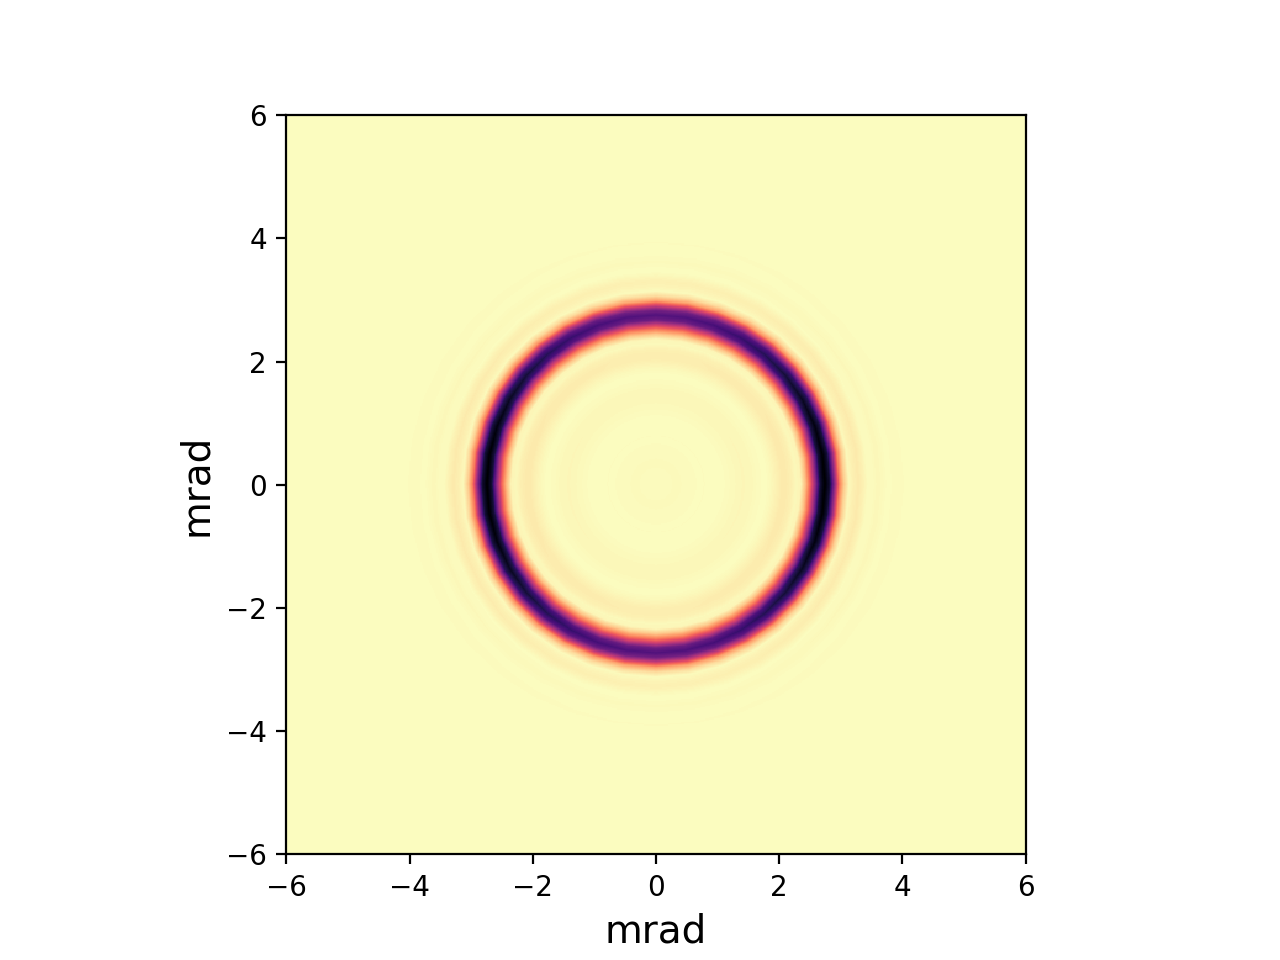

In [4]:
# Plot the spot observed with a band-filter

kFilter = 0.93 * k_res
kBand = 0.003 * kFilter
k = calc.Args['omega'][:,None,None]
spect_filter = np.exp( -(k-kFilter)**2/kBand**2 ) 

spot, extent = calc.get_spot_cartesian( bins=(600,600), lambda0_um=2e4, th_part=0.3, 
                                        spect_filter=spect_filter )

plt.figure()
plt.imshow(spot, extent=extent*1e3, cmap=plt.cm.magma_r )
[ lab('mrad', size=14) for lab in (plt.xlabel, plt.ylabel) ];

In [5]:
# Export the whole spectrum to a VTK file

#calc.exportToVTK(lambda0_um=1)